# Churn Prediction – Customer Retention Intelligence

## Business Objective
Customer acquisition is expensive. Retaining existing customers is often
5–7x cheaper than acquiring new ones.

The goal of this analysis is to:
- Identify customers at high risk of churn
- Understand key drivers of churn
- Quantify potential revenue at risk
- Enable targeted retention strategies

This notebook focuses **only on modeling and business interpretation**.
All feature engineering and joins were completed upstream in the Silver layer.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

RANDOM_STATE = 42


In [29]:
silver_path = Path("../data/silver")

df = pd.read_parquet(silver_path / "customer_churn_features.parquet")

df.head()




,customer_unique_id,order_count,total_spend_x,avg_order_value_x,std_order_value,total_items,avg_items_per_order,avg_freight_ratio,avg_delivery_days,avg_review_score,...,days_active,orders_per_month,recency,frequency,monetary,R,F,M,RFM_SCORE,churn
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,141.90,0.0,1,1.0,0.084567,6.0,5.0,...,0,1.0,112,1,141.90,4,1,4,9,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,27.19,0.0,1,1.0,0.304892,3.0,4.0,...,0,1.0,115,1,27.19,4,1,1,6,1
2,0000f46a3911fa3c0805444483337064,1,86.22,86.22,0.0,1,1.0,0.199722,25.0,3.0,...,0,1.0,537,1,86.22,1,1,2,4,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,43.62,0.0,1,1.0,0.404172,20.0,4.0,...,0,1.0,321,1,43.62,2,1,1,4,1
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,196.89,0.0,1,1.0,0.085784,13.0,5.0,...,0,1.0,288,1,196.89,2,1,4,7,1


In [3]:
df.shape


(93358, 26)

In [4]:
df["churn"].value_counts(normalize=True)


churn
1    0.800874
0    0.199126
Name: proportion, dtype: float64

### Baseline Churn Rate

Churn is defined as:
> A customer with no purchase in the last **90 days** from dataset end.

This baseline helps measure:
- Severity of retention problem
- Expected model difficulty


In [5]:
churn_rate = df["churn"].mean()
print(f"Baseline churn rate: {churn_rate:.2%}")


Baseline churn rate: 80.09%


In [6]:
target = "churn"

drop_cols = [
    "customer_unique_id",
    "churn"
]

X = df.drop(columns=drop_cols)
y = df[target]

X.shape, y.shape


((93358, 24), (93358,))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train churn rate:", y_train.mean())
print("Test churn rate:", y_test.mean())


Train churn rate: 0.8008729882441153
Test churn rate: 0.8008783204798628


In [9]:
X_train.dtypes


order_count                          int64
total_spend_x                      float64
avg_order_value_x                  float64
std_order_value                    float64
total_items                          int64
avg_items_per_order                float64
avg_freight_ratio                  float64
avg_delivery_days                  float64
avg_review_score                   float64
single_purchase_customer             int64
total_orders                         int64
total_spend_y                      float64
avg_order_value_y                  float64
first_order                 datetime64[ns]
last_order                  datetime64[ns]
days_active                          int64
orders_per_month                   float64
recency                              int64
frequency                            int64
monetary                           float64
R                                    int64
F                                    int64
M                                    int64
RFM_SCORE  

In [10]:
# Customer tenure
X_train["customer_tenure_days"] = (
    X_train["last_order"] - X_train["first_order"]
).dt.days

# Calendar features
X_train["first_order_month"] = X_train["first_order"].dt.month
X_train["first_order_year"] = X_train["first_order"].dt.year
X_train["last_order_month"] = X_train["last_order"].dt.month
X_train["last_order_year"] = X_train["last_order"].dt.year

# Drop raw datetime columns
X_train = X_train.drop(columns=["first_order", "last_order"])


In [11]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [13]:
# Customer tenure
X_test["customer_tenure_days"] = (
    X_test["last_order"] - X_test["first_order"]
).dt.days

# Calendar features
X_test["first_order_month"] = X_test["first_order"].dt.month
X_test["first_order_year"] = X_test["first_order"].dt.year
X_test["last_order_month"] = X_test["last_order"].dt.month
X_test["last_order_year"] = X_test["last_order"].dt.year

# Drop raw datetime columns
X_test = X_test.drop(columns=["first_order", "last_order"])


In [14]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]


In [15]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3718
           1       1.00      1.00      1.00     14954

    accuracy                           1.00     18672
   macro avg       1.00      1.00      1.00     18672
weighted avg       1.00      1.00      1.00     18672



In [16]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 1.000


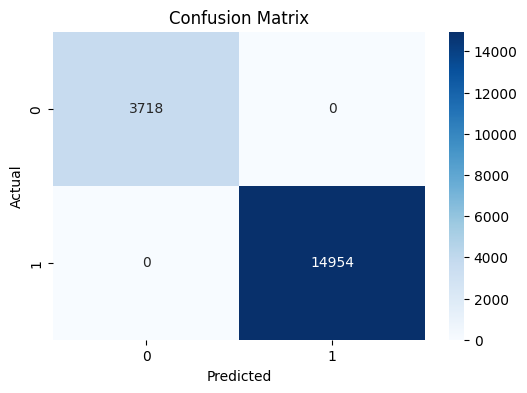

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


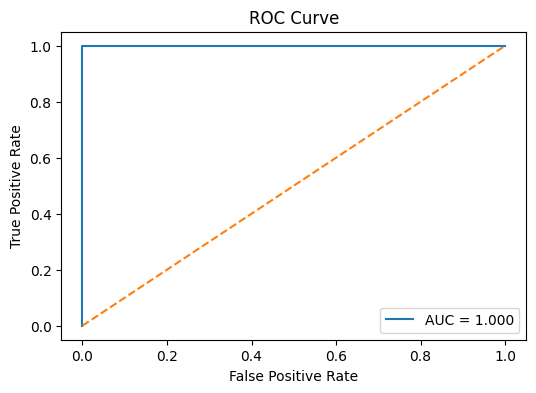

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


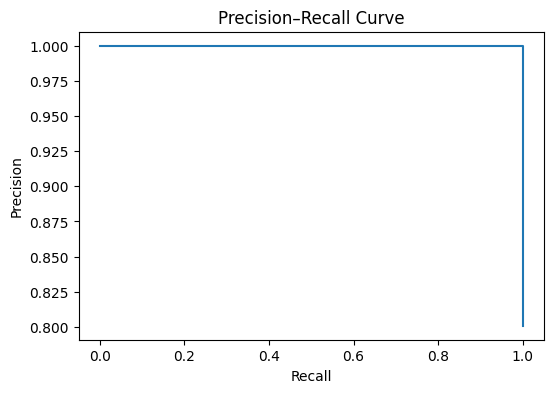

In [19]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


In [22]:
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importances.head(15)


,feature,importance
18,R,0.297232
15,recency,0.255150
25,last_order_month,0.115624
24,first_order_year,0.105293
26,last_order_year,0.100646
23,first_order_month,0.086230
21,RFM_SCORE,0.027507
7,avg_delivery_days,0.007045
22,customer_tenure_days,0.000809
19,F,0.000694


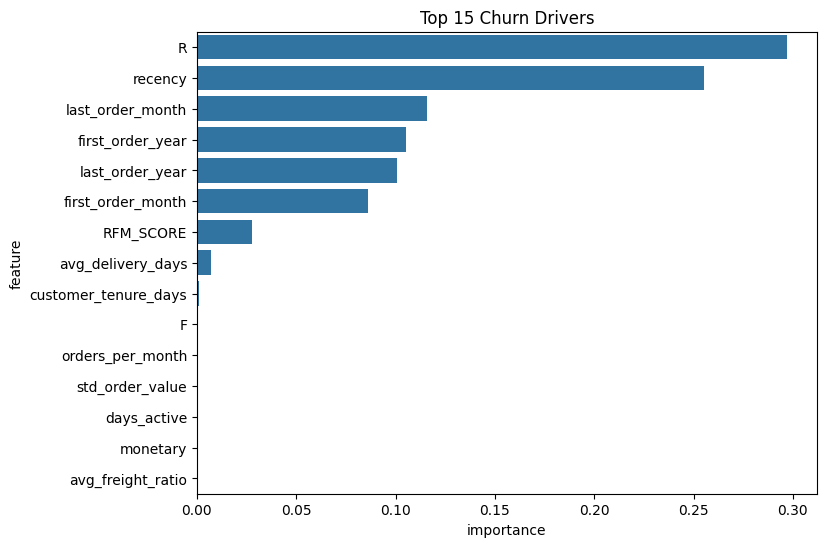

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances.head(15),
    x="importance",
    y="feature"
)
plt.title("Top 15 Churn Drivers")
plt.show()


In [25]:
df_test = X_test.copy()
df_test["churn_probability"] = y_proba
df_test["actual_churn"] = y_test.values
df_test["total_spend"] = df.loc[X_test.index, "total_spend_y"]


high_risk = df_test[df_test["churn_probability"] > 0.7]

revenue_at_risk = high_risk["total_spend"].sum()

print(f"High-risk customers: {len(high_risk):,}")
print(f"Potential revenue at risk: {revenue_at_risk:,.2f}")


High-risk customers: 14,954
Potential revenue at risk: 2,409,106.56


In [26]:
output = df_test[["churn_probability"]].copy()
output.to_parquet(
    silver_path / "churn_predictions.parquet",
    index=False
)
